# Automated Object Detection using YOLOv3.
This assignment is a modified version of source https://colab.research.google.com/github/zzh8829/yolov3-tf2/blob/master/colab_gpu.ipynb

You will learn about object detection using the very powerful YOLO model. Many of the ideas in this notebook are described in the two YOLO papers: Redmon et al., 2016 and Redmon and Farhadi, 2016.

You will learn how to use a pre-trained model and fine tune it on new data.

# A. Start by connecting colab to your local Google Drive.

# Create a Folder named 'YOLOv3' in your Google Drive. 
## This is the folder where all code and data will be collected.

In [1]:
!gsutil -m cp gs://fourth-brain-course-files/week6-object-detection/test_images.zip .

Copying gs://fourth-brain-course-files/week6-object-detection/test_images.zip...
/ [1/1 files][959.9 KiB/959.9 KiB] 100% Done                                    
Operation completed over 1 objects/959.9 KiB.                                    


In [2]:
!unzip test_images.zip

Archive:  test_images.zip
   creating: test_images/
  inflating: test_images/0004.jpg    
  inflating: test_images/giraffe.jpg  
  inflating: test_images/test.jpg    


In [61]:
import os
# use this function to upload folders to gcs
def upload_directory_to_gcs(directory):
  command = f"gsutil -m cp -r {directory} gs://fourth-brain-course-files/week6-object-detection/"
  result = os.system(command)
  if result:
    print(f"Unable to save directory to GCS. Write permissions may have been revoked.")

  return result

def upload_file_to_gcs(filepath):
  command = f"gsutil -m cp {filepath} gs://fourth-brain-course-files/week6-object-detection/"
  result = os.system(command)
  if result:
    print(f"Unable to save directory to GCS. Write permissions may have been revoked.")

  return result

### 1. Now lets install all requirements for the code base! 
This can take sometime!

In [3]:
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 410, done.
remote: Total 410 (delta 0), reused 0 (delta 0), pack-reused 410
Receiving objects: 100% (410/410), 4.23 MiB | 23.68 MiB/s, done.
Resolving deltas: 100% (236/236), done.
/content/yolov3-tf2
Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 394.7MB 43kB/s 
     |████████████████████████████████| 28.7MB 121kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Running setup.py develop for yolov3-tf2


##### 2.  Check Tensorflow2 version

In [7]:
#Ensure you are located inside directory yolov3-tf2/. If not use the command 
#%cd yolov3-tf2
!ls

checkpoints	 data		  README.md		train.py
colab_gpu.ipynb  detect.py	  requirements-gpu.txt	yolov3_tf2
conda-cpu.yml	 detect_video.py  requirements.txt	yolov3_tf2.egg-info
conda-gpu.yml	 docs		  setup.py
convert.py	 LICENSE	  tools


In [8]:
import tensorflow as tf
tf.__version__

'2.4.0'

# Download the test_images.zip, unzip them and manually move the images to './data/' folder. You will be required to run all experiments on these test images. You may have to rerun the notebook till this point to refresh the data folders.

##### 3.  Now we retrieve a Pretrained model weights.
To learn more about DarkNet and its pretrained models refer to: https://towardsdatascience.com/custom-object-detection-using-darknet-9779170faca2

In [9]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

--2021-05-11 22:26:48--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M  20.8MB/s    in 12s     

2021-05-11 22:27:01 (19.3 MB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

2021-05-11 22:27:01.595419: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-11 22:27:03.484086: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-11 22:27:03.485003: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-11 22:27:03.541556: I tensorflow/stream_executor/cuda/cuda_gpu_exec

## 4 - Problem Statement

If you are building an objector for a self-driving car use case, a critical component of this project, is a specific object detector, i.e cars only or pedestrians only etc. To collect data, you've mounted a camera to the hood (meaning the front) of the car, which takes pictures of the road ahead every few seconds while you drive around. 

<center>
<video width="400" height="200" src="https://www.dropbox.com/s/804jv98ez3dllqd/road_video_compressed2.mp4?raw=1" type="video/mp4" controls>
</video>
</center>

<caption><center> Pictures taken from a car-mounted camera while driving around Silicon Valley. <br> We thank [drive.ai](htps://www.drive.ai/) for providing this dataset.
</center></caption>

You've gathered all these images into a folder and have labelled them by drawing bounding boxes around every car you found. Here's an example of what your bounding boxes look like.

<img src="https://www.dropbox.com/s/ljv8l2s15eizrlg/box_label.png?raw=1" style="width:500px;height:250;">
<caption><center> <u> **Figure 1** </u>: **Definition of a box**<br> </center></caption>

If you have 80 classes that you want the object detector to recognize, you can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1 and the rest of which are 0. The video lectures had used the latter representation; in this notebook, we will use both representations, depending on which is more convenient for a particular step.  

In this exercise, you will learn how "You Only Look Once" (YOLOv3) performs object detection, and then apply it to object detection. YOLO models are training cost intensive, so we will begin with pre-trained weights and then fine tune the training process for a particular object class only!

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### 5.1 - Model details

#### Inputs and outputs
- The **input** is a batch of images, and each image has the shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

#### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  For this assignment, 5 anchor boxes were chosen for you (to cover the 80 classes), and stored in the file './model_data/yolo_anchors.txt'
* The dimension for anchor boxes is the second to last dimension in the encoding: $(m, n_H,n_W,anchors,classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).  


#### Encoding
Let's look in greater detail at what this encoding represents. 

<img src="https://www.dropbox.com/s/bpzqt82newudmvk/architecture.png?raw=1" style="width:700px;height:400;">
<caption><center> <u> **Figure 2** </u>: **Encoding architecture for YOLO**<br> </center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

<img src="https://www.dropbox.com/s/3rhn01o6ud2dv89/flatten.png?raw=1" style="width:700px;height:400;">
<caption><center> <u> **Figure 3** </u>: **Flattening the last two last dimensions**<br> </center></caption>

#### 5.2 Class score

Now, for each box (of each cell) we will compute the following element-wise product and extract a probability that the box contains a certain class.  
The class score is $score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.

<img src="https://www.dropbox.com/s/04y7n9h1w38mkmd/probability_extraction.png?raw=1" style="width:700px;height:400;">
<caption><center> <u> **Figure 4** </u>: **Find the class detected by each box**<br> </center></caption>

##### Example of figure 4
* In figure 4, let's say for box 1 (cell 1), the probability that an object exists is $p_{1}=0.60$.  So there's a 60% chance that an object exists in box 1 (cell 1).  
* The probability that the object is the class "category 3 (a car)" is $c_{3}=0.73$.  
* The score for box 1 and for category "3" is $score_{1,3}=0.60 \times 0.73 = 0.44$.  
* Let's say we calculate the score for all 80 classes in box 1, and find that the score for the car class (class 3) is the maximum.  So we'll assign the score 0.44 and class "3" to this box "1".

#### 5.3 Visualizing classes
Here's one way to visualize what YOLO is predicting on an image:
- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across the 80 classes, one maximum for each of the 5 anchor boxes).
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 

<img src="https://www.dropbox.com/s/9r6cbdtsa947i6x/proba_map.png?raw=1" style="width:300px;height:300;">
<caption><center> <u> **Figure 5** </u>: Each one of the 19x19 grid cells is colored according to which class has the largest predicted probability in that cell.<br> </center></caption>

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm. 


#### 5.4 Visualizing bounding boxes
Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="https://www.dropbox.com/s/x8abfjj9hgwu638/anchor_map.png?raw=1" style="width:200px;height:200;">
<caption><center> <u> **Figure 6** </u>: Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

#### Non-Max suppression
In the figure above, we plotted only boxes for which the model had assigned a high probability, but this is still too many boxes. You'd like to reduce the algorithm's output to a much smaller number of detected objects.  

To do so, you'll use **non-max suppression**. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class; either due to the low probability of any object, or low probability of this particular class).
- Select only one box when several boxes overlap with each other and detect the same object.

Now that we have a better understanding of the undelying model, lets apply the pre-trained detector on sample images.


### 6. Load the libraries, model weights and images

In [ ]:
import sys
from PIL import Image
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')

#Sample image is girl.png within data folder. 80 classes detection from MS COCO data set.
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 7. Apply the pre-trained detector on a sample image from the yolov3-tf2/data folder

I0511 22:34:45.411873 140036505237376 <ipython-input-11-8e38433b51b4>:10] weights loaded
I0511 22:34:45.414782 140036505237376 <ipython-input-11-8e38433b51b4>:13] classes loaded
I0511 22:34:47.169790 140036505237376 <ipython-input-11-8e38433b51b4>:24] time: 1.7154555320739746
I0511 22:34:47.171741 140036505237376 <ipython-input-11-8e38433b51b4>:26] detections:
I0511 22:34:47.180377 140036505237376 <ipython-input-11-8e38433b51b4>:30] 	car, 0.9966800212860107, [0.26270664 0.34669653 0.40587908 0.5401914 ]
I0511 22:34:47.190776 140036505237376 <ipython-input-11-8e38433b51b4>:30] 	bus, 0.9951198101043701, [0.67014587 0.17855005 0.9937171  0.5290146 ]
I0511 22:34:47.197837 140036505237376 <ipython-input-11-8e38433b51b4>:30] 	person, 0.9870266914367676, [0.6138846 0.3450544 0.6877058 0.7753   ]
I0511 22:34:47.204826 140036505237376 <ipython-input-11-8e38433b51b4>:30] 	bus, 0.9826598763465881, [0.3228875  0.15145975 0.6138201  0.506682  ]
I0511 22:34:47.211064 140036505237376 <ipython-input-1

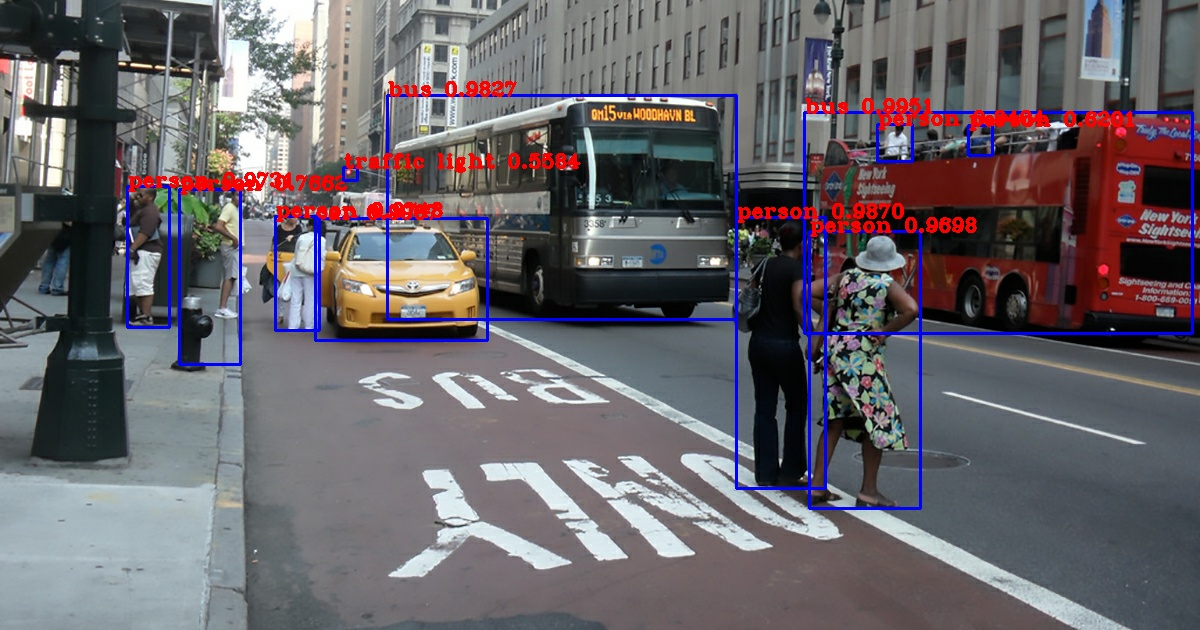

In [11]:
# Modify the name for all the images in the test_images folder
FLAGS.image = 'data/street.jpg'

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

# Task 1: Repeat object detector on images from the test_images folder. 
Apply the detector above on all the test images from the test_images folder (3 images)

## Modify FLAGS.image and submit output images in a folder.

In [57]:
def annotate_image(flags, save_image=True):
  if flags.tiny:
      yolo = YoloV3Tiny(classes=flags.num_classes)
  else:
      yolo = YoloV3(classes=flags.num_classes)
        
  yolo.load_weights(flags.weights).expect_partial()
  logging.info('weights loaded')

  class_names = [c.strip() for c in open(flags.classes).readlines()]
  logging.info('classes loaded')

  img_raw = tf.image.decode_image(
      open(flags.image, 'rb').read(), channels=3)

  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, flags.size)

  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  logging.info('time: {}'.format(t2 - t1))

  logging.info('detections:')
  for i in range(nums[0]):
      logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                          np.array(scores[0][i]),
                                          np.array(boxes[0][i])))

  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

  from IPython.display import display
  from PIL import Image
  from pathlib import Path
  image_to_display = Image.fromarray(img)
  display(image_to_display)

  if save_image:
    image_location = Path(flags.image)
    image_dir = Path("/content/annotated_images")
    if not image_dir.exists():
      image_dir.mkdir()

    path_to_image = image_dir / image_location.name
    image_to_display.save(str(path_to_image))
  
  return image_to_display

I0511 23:17:00.634904 140036505237376 <ipython-input-57-7f862be32bfe>:8] weights loaded
I0511 23:17:00.636920 140036505237376 <ipython-input-57-7f862be32bfe>:11] classes loaded
I0511 23:17:00.780023 140036505237376 <ipython-input-57-7f862be32bfe>:22] time: 0.12424921989440918
I0511 23:17:00.782624 140036505237376 <ipython-input-57-7f862be32bfe>:24] detections:
I0511 23:17:00.792042 140036505237376 <ipython-input-57-7f862be32bfe>:28] 	car, 0.9945942759513855, [0.08390437 0.4181878  0.17409326 0.47571415]
I0511 23:17:00.798577 140036505237376 <ipython-input-57-7f862be32bfe>:28] 	car, 0.9919448494911194, [0.00217113 0.45459333 0.09452537 0.57086265]
I0511 23:17:00.804951 140036505237376 <ipython-input-57-7f862be32bfe>:28] 	car, 0.9793890118598938, [0.30968887 0.39875886 0.4104424  0.45354083]
I0511 23:17:00.811277 140036505237376 <ipython-input-57-7f862be32bfe>:28] 	car, 0.9760374426841736, [0.4204707  0.3865328  0.50878394 0.43637237]
I0511 23:17:00.815623 140036505237376 <ipython-input-

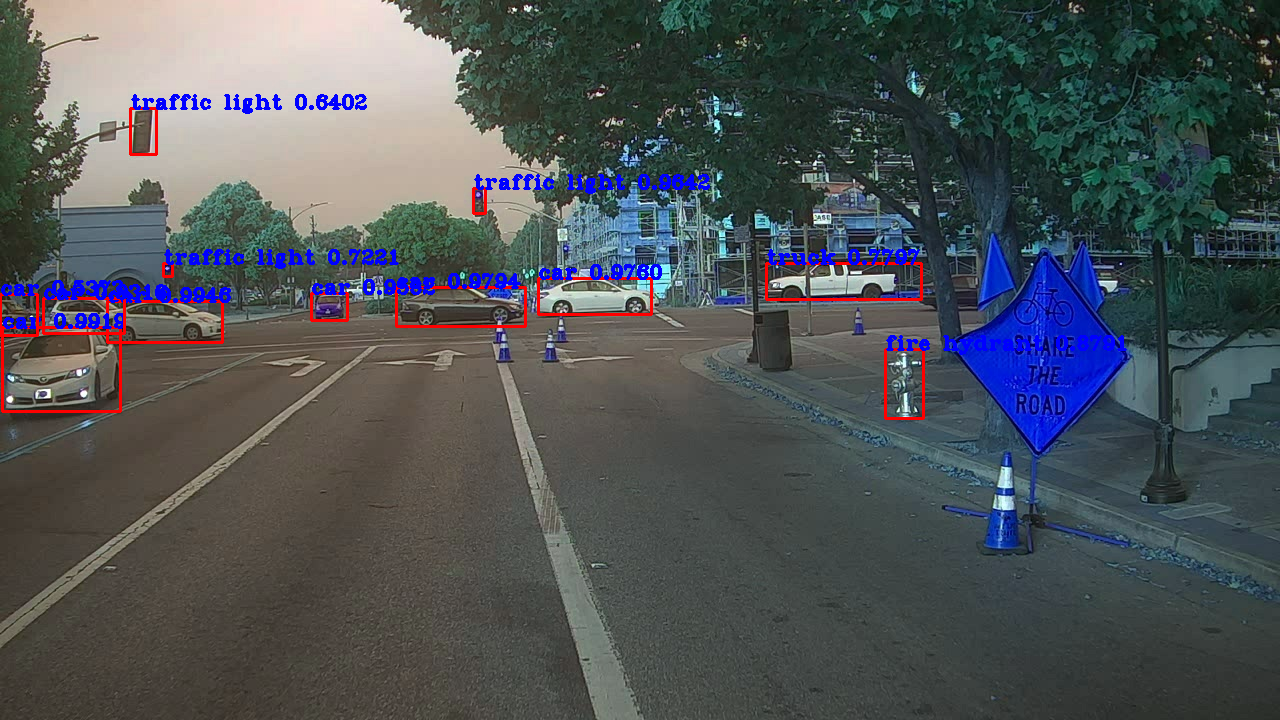

In [58]:
FLAGS.image = "/content/test_images/0004.jpg"
img = annotate_image(FLAGS, True)

I0511 23:17:31.700168 140036505237376 <ipython-input-57-7f862be32bfe>:8] weights loaded
I0511 23:17:31.702763 140036505237376 <ipython-input-57-7f862be32bfe>:11] classes loaded
I0511 23:17:31.834297 140036505237376 <ipython-input-57-7f862be32bfe>:22] time: 0.11523103713989258
I0511 23:17:31.838628 140036505237376 <ipython-input-57-7f862be32bfe>:24] detections:
I0511 23:17:31.846435 140036505237376 <ipython-input-57-7f862be32bfe>:28] 	giraffe, 0.9978438019752502, [0.30420482 0.0965673  0.8799007  0.8699311 ]
I0511 23:17:31.852641 140036505237376 <ipython-input-57-7f862be32bfe>:28] 	zebra, 0.8449257016181946, [0.52784646 0.40066803 0.8689227  0.90139806]


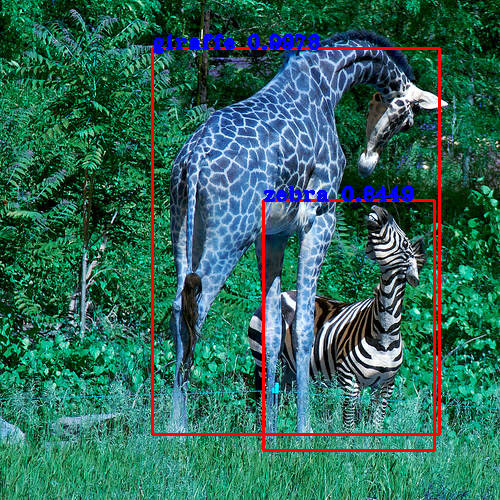

In [59]:
FLAGS.image = "/content/test_images/giraffe.jpg"
img = annotate_image(FLAGS, True)

I0511 23:17:45.537634 140036505237376 <ipython-input-57-7f862be32bfe>:8] weights loaded
I0511 23:17:45.540759 140036505237376 <ipython-input-57-7f862be32bfe>:11] classes loaded
I0511 23:17:45.675830 140036505237376 <ipython-input-57-7f862be32bfe>:22] time: 0.11801934242248535
I0511 23:17:45.678326 140036505237376 <ipython-input-57-7f862be32bfe>:24] detections:
I0511 23:17:45.688337 140036505237376 <ipython-input-57-7f862be32bfe>:28] 	car, 0.9992826581001282, [0.27649012 0.4105447  0.59023607 0.896624  ]
I0511 23:17:45.694800 140036505237376 <ipython-input-57-7f862be32bfe>:28] 	car, 0.9985067844390869, [0.59527993 0.3980793  0.7218013  0.56224144]
I0511 23:17:45.698833 140036505237376 <ipython-input-57-7f862be32bfe>:28] 	car, 0.996269941329956, [0.7381854  0.44752878 1.0068752  0.9742908 ]
I0511 23:17:45.703952 140036505237376 <ipython-input-57-7f862be32bfe>:28] 	car, 0.9922270774841309, [0.7231026  0.4083751  0.82352275 0.5277095 ]
I0511 23:17:45.709251 140036505237376 <ipython-input-5

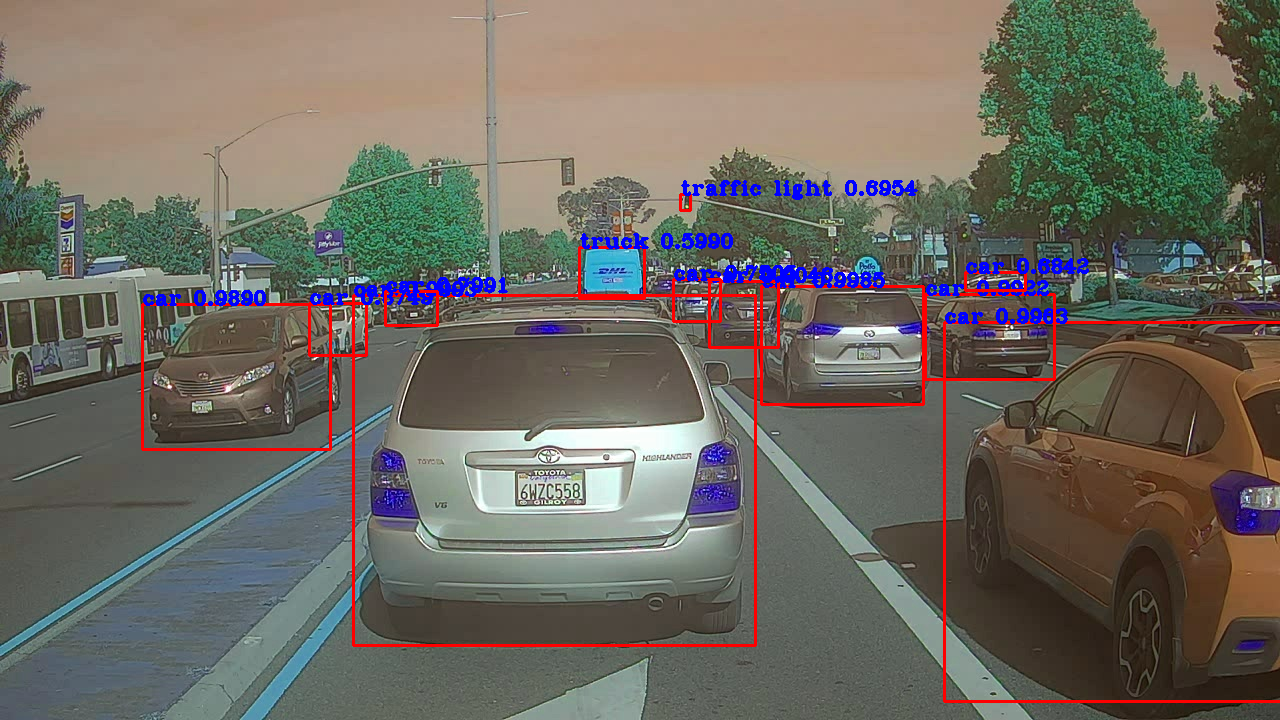

In [60]:
FLAGS.image = "/content/test_images/test.jpg"
img = annotate_image(FLAGS, True)

In [63]:
!zip -r /content/annotated_images.zip /content/annotated_images

  adding: content/annotated_images/ (stored 0%)
  adding: content/annotated_images/giraffe.jpg (deflated 0%)
  adding: content/annotated_images/test.jpg (deflated 1%)
  adding: content/annotated_images/0004.jpg (deflated 1%)


In [64]:
upload_directory_to_gcs("/content/annotated_images")

0

In [65]:
upload_file_to_gcs("/content/annotated_images.zip")

0

## 8. Now to retrain/fine tune the detector for additional images
Download the PASCAL VOC 2007 data set. 
Learn about the dataset at https://www.kaggle.com/zaraks/pascal-voc-2007
### (Caution!) This step will take sometime

In [66]:
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -O ./data/voc2007_raw.tar
!mkdir -p ./data/voc2007_raw
!tar -xf ./data/voc2007_raw.tar -C ./data/voc2007_raw

URL transformed to HTTPS due to an HSTS policy
--2021-05-11 23:20:23--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘./data/voc2007_raw.tar’

./data/voc2007_raw. 100%[===================>] 438.72M  20.7MB/s    in 22s     

2021-05-11 23:20:45 (20.3 MB/s) - ‘./data/voc2007_raw.tar’ saved [460032000/460032000]



## 9. Next, use the voc2012.py file to split the above VOC 2007 data to training and validation

In [67]:
!python tools/voc2012.py \
  --data_dir './data/voc2007_raw/VOCdevkit/VOC2007' \
  --split train \
  --output_file ./data/voc_train.tfrecord

!python tools/voc2012.py \
  --data_dir './data/voc2007_raw/VOCdevkit/VOC2007' \
  --split val \
  --output_file ./data/voc_val.tfrecord

2021-05-11 23:20:48.845501: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
I0511 23:20:50.973135 140187397744512 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
I0511 23:20:50.973743 140187397744512 voc2012.py:97] Image list loaded: 2501
100% 2501/2501 [00:02<00:00, 1044.58it/s]
I0511 23:20:53.369839 140187397744512 voc2012.py:106] Done
2021-05-11 23:20:54.033590: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
I0511 23:20:56.023918 140391668094848 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow':

# 10. Run the commands below for 5 or more times and report your findings below.

2021-05-11 23:22:20.488128: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
I0511 23:22:22.377162 140201818023808 visualize_dataset.py:22] classes loaded
2021-05-11 23:22:22.377690: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-11 23:22:22.378551: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-11 23:22:22.383823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-11 23:22:22.384579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681

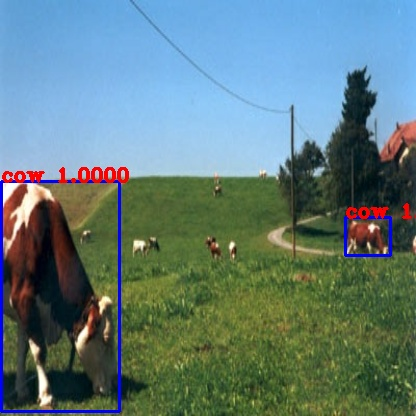

In [73]:
#Run this cell 5 or more times and save the output images.
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names

from IPython.display import Image
Image(filename='./output.jpg')

# Task 2: Comment on your observations on object detection for the 5 sample Pascal VOC images from above.

The model seems to get everything correct with what is essentially a 100% certainty. I did not see any misclassifications. 

### 10. Next retrain the model using the PASCAL VOC train/validation images below.
## (Caution) This will take sometime!

In [74]:
!python train.py \
	--dataset ./data/voc_train.tfrecord \
	--val_dataset ./data/voc_val.tfrecord \
	--classes ./data/voc2012.names \
	--num_classes 20 \
	--mode fit --transfer darknet \
	--batch_size 16 \
	--epochs 3 \
	--weights ./checkpoints/yolov3.tf \
	--weights_num_classes 80 

2021-05-11 23:23:13.973770: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-11 23:23:15.971974: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-11 23:23:15.972777: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-11 23:23:15.977644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-11 23:23:15.978193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-05-11 23:23:15.978229: I tensorflow/stream_executor/platform/def

# Task 3: Lets analyze the training process and figure out what is the role of specific functions.
## Step 1: Under GDrive folder YOLOv3->yolov3-tf2 analyze the functions in 'train.py'. Write down the steps that the function is performing [Similar to pseudo-code writing]. Feel free to discuss this over slack.

## Step 2: Under GDrive folder YOLOv3->yolov3-tf2->yolov3-tf2 analyze the functions in 'models.py'. Can you match these functions with the model steps mentioned in Steps 4 and 5 above?

The file **train.py** is responsible for figuring out how we want to train the model and then doing the training. It does so with the use of the flags (thar we used abovoe). First it checks if we actually want to use a pre-trained network and if yes what kind of pre-trained architecture weights do we want to use. It also checks if we want to use the full YOLOv3 or a tiny version. It checks whether or not we want to finetune the model, which tells it which layers to freeze and which to leave unfrozen for training (if any). 

Finally the model is trained, while logging info and utilizing callbacks to make the learning process more automated/smoother. 

In the file **models.py** there appear to be a set of functions responsible for returning Model instances as well as functions to help with tasks such as finding box coordiantes and class probabilities as well as the probability that an object is present in the grid.

```
    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss
```

The above lines seem to be responsible for obtaining said values.



### 11. Apply the fine tuned weights on the images from test_images folder.
# Task 4: Collect your outputs on the images from test_images folder.
This can be achieved by modifying FLAGS.image.

/content/test_images/0004.jpg


I0511 23:40:26.320477 140036505237376 <ipython-input-86-b403da44101a>:18] weights loaded
I0511 23:40:26.327625 140036505237376 <ipython-input-86-b403da44101a>:22] classes loaded
I0511 23:40:26.458639 140036505237376 <ipython-input-86-b403da44101a>:33] time: 0.11490416526794434
I0511 23:40:26.460134 140036505237376 <ipython-input-86-b403da44101a>:35] detections:


['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


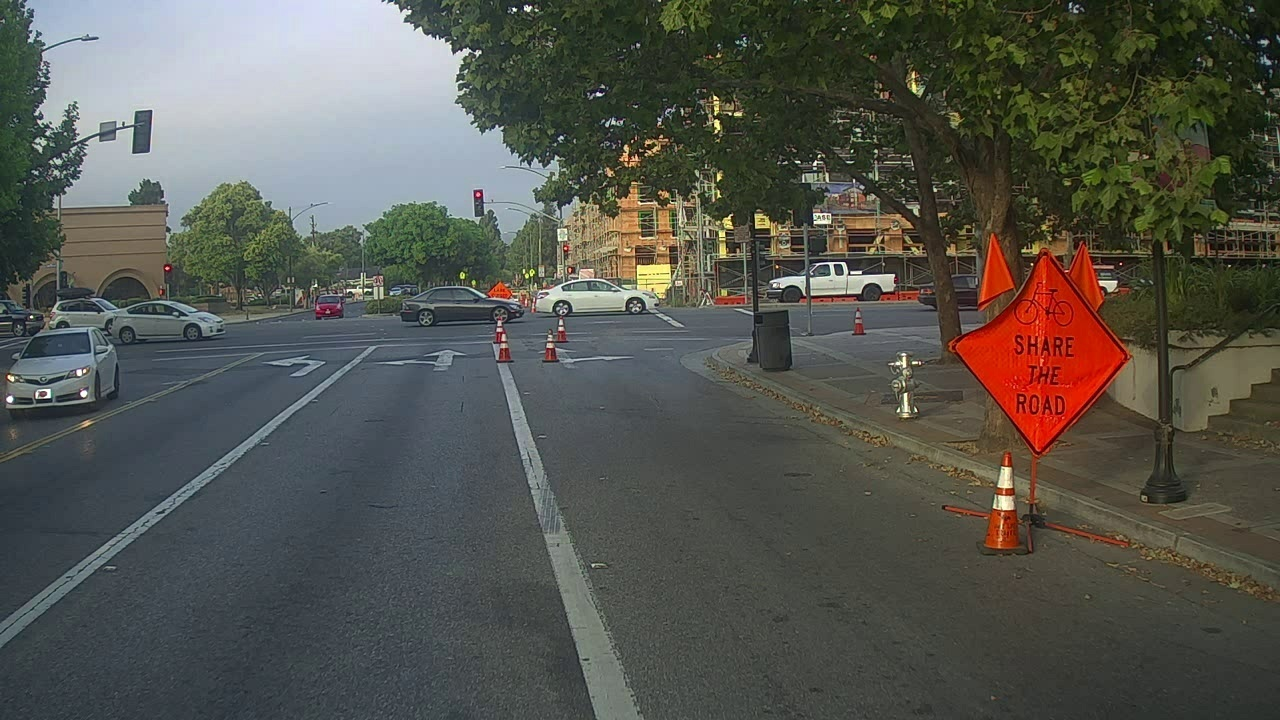

False

In [86]:
FLAGS.num_classes = 20
FLAGS.classes = 'data/voc2012.names'
FLAGS.weights = 'checkpoints/yolov3_train_3.tf'
img_file_name = "0004.jpg"
FLAGS.image = f'/content/test_images/{img_file_name}'
print(FLAGS.image)

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.2
FLAGS.yolo_score_threshold = 0.2

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
print(class_names)
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
im = cv2.imencode('.jpg', img)[1]
display(Image(data=bytes(im), width=800))

directory = Path("/content/Training/")
if not directory.exists():
  directory.mkdir()
cv2.imwrite(f"/content/Training/{img_file_name}", im)

# We notice that since fine tuning had lesser class categories, we now observe fewer bounding boxes. This is the fine-tuning process.

In [85]:
!mkdir /content/No_training
!mv /content/annotated_images/* /content/No_training/

In [92]:
!mv /content/*aining /content/annotated_images

In [93]:
!zip -r /content/submission_images.zip /content/annotated_images

  adding: content/annotated_images/ (stored 0%)
  adding: content/annotated_images/Training/ (stored 0%)
  adding: content/annotated_images/Training/giraffe.jpg (stored 0%)
  adding: content/annotated_images/Training/test.jpg (stored 0%)
  adding: content/annotated_images/Training/0004.jpg (stored 0%)
  adding: content/annotated_images/No_training/ (stored 0%)
  adding: content/annotated_images/No_training/giraffe.jpg (deflated 0%)
  adding: content/annotated_images/No_training/test.jpg (deflated 1%)
  adding: content/annotated_images/No_training/0004.jpg (deflated 1%)


In [94]:
upload_file_to_gcs("/content/submission_images.zip")

0

# Final Submission for this assignment includes a folder with following structure
``` Results
      |_______No training
                  |____004.jpg
                  |_____giraffe.jpg
                  |_____test.jpg
      |_______Training
                  |____004.jpg
                  |_____giraffe.jpg
                  |_____test.jpg
                  
```

In [ ]:
!mkdir

# Here folder 'No training' contains images with the bounding boxes before fine tuning and 'Training' contains images with the bounding boxes after fine tuning.